In [2]:
!pip install pydub
!apt-get install ffmpeg -y
!apt-get install -y rubberband-cli
!pip install pyrubberband

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  rubberband-cli
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 87.5 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 rubberband-cli amd64 2.0.0-2 [87.5 kB]
Fetched 87.5 kB in 18s (4,932 B/s)
Selecting previously unselected package rubberband-cli.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../rubberband-cli_2.0.0-2_amd64.deb ...
Unpacking rubberband-cli (2.0.0-2) ...
Setting up rubberband-cli (2.0.0-2) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
# !pip install librosa
# #conda install -c conda-forge librosa

In [3]:
#ספריות רלוונטיות לאודיו
import librosa
import librosa.display
from IPython.display import Audio
from pydub import AudioSegment
import pyrubberband as pyrb # לשינוי קצב
#ספריות נוספות
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
#import yt_dlp

In [4]:
librosa.util.list_examples()

AVAILABLE EXAMPLES
--------------------------------------------------------------------
brahms    	Brahms - Hungarian Dance #5
choice    	Admiral Bob - Choice (drum+bass)
fishin    	Karissa Hobbs - Let's Go Fishin'
humpback  	Glacier Bay 60-second clip humpback whale song November 2020
libri1    	Ashiel Mystery - A Detective Story, chapter 2, narrated by Garth Comira
libri2    	The Age of Chivalry / Chapter 18: Perceval / Read by Anders Lankford
libri3    	Sense and Sensibility / Chapter 18 / Jane Austen / Read by Heather Barnett
nutcracker	Tchaikovsky - Dance of the Sugar Plum Fairy
pistachio 	The Piano Lady - Pistachio Ice Cream Ragtime
robin     	Bird Whistling, Robin, Single, 13.wav / InspectorJ
sweetwaltz	Setuniman - Sweet Waltz
trumpet   	Mihai Sorohan - Trumpet loop
vibeace   	Kevin MacLeod - Vibe Ace


In [6]:
file_path =  librosa.example('brahms')
signal , sr =librosa.load(file_path)

In [7]:
sr #  כמה דגימות בשניה

22050

In [8]:
signal #array

array([-3.1496835e-05,  4.5770039e-06,  6.3310695e-06, ...,
       -1.1488050e-05, -7.4060167e-06, -8.0729505e-06], dtype=float32)

In [9]:
signal.shape

(1010880,)

In [10]:
len(signal)/sr #אורך הקטע בשניות

45.844897959183676

In [11]:
file_path =  librosa.example('trumpet')
signal , sr =librosa.load(file_path)

In [28]:
file_path =  librosa.example('libri1')
signal , sr =librosa.load(file_path)
Audio (data = signal, rate = sr)

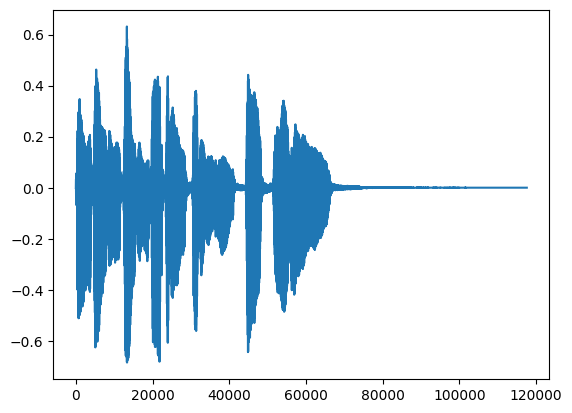

In [13]:
plt.plot(signal)

<ipython-input-16-e28397d8419e>:3: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(sgram)


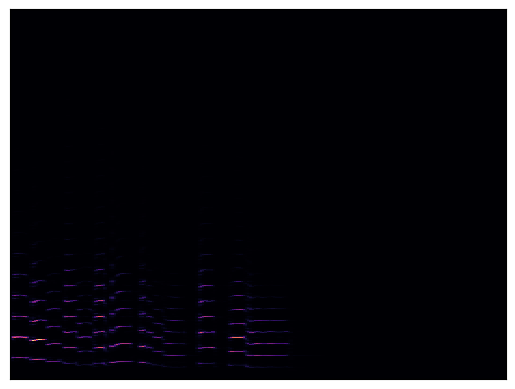

In [16]:
#spectogram
sgram = librosa.stft(signal)
librosa.display.specshow(sgram)

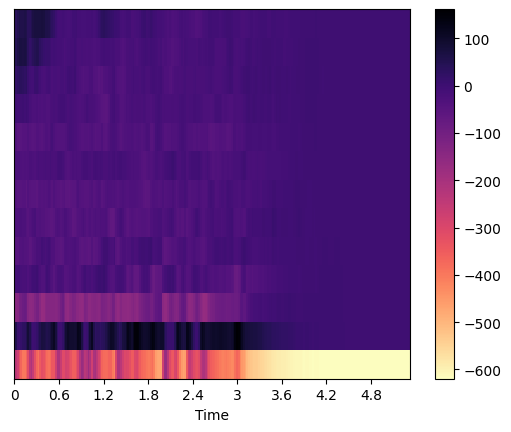

In [17]:
#mel spectogram
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc =13)
librosa.display.specshow(mfccs,
                         sr =sr,
                         x_axis ='time',
                         cmap = 'magma_r'
                         )
plt.colorbar()

In [18]:
file_path =  librosa.example('trumpet')
signal , sr =librosa.load(file_path)
Audio (data = signal, rate = sr)

In [20]:
# 1 הורדת קובצי אודיו (נבחר מתוך דוגמאות של librosa)
file_paths = [
    librosa.example('trumpet'),
    librosa.example('brahms'),
    librosa.example('nutcracker'),
    librosa.example('fishin'),
    librosa.example('vibeace'),
    librosa.example('choice'),
]
labels = [
    'instrument',  # trumpet
    'classical',   # brahms
    'classical',   # nutcracker
    'instrument',  # fishin
    'instrument',  # vibeace
    'classical',   # choice
]

# 2 חילוץ תכונות MFCC מכל קובץ
features = []
for file in file_paths:
    signal, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs.T, axis=0))

# 3 המרת תגיות למספרים
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# 4 פיצול נתונים לאימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

# 5 אימון מודל Random Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# 6 ניבוי ודיוק
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Accuracy: 0.00%


In [22]:
xgb_model =  XGBClassifier(eval_metric = 'logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(acc_xgb)

0.5


In [23]:
#הוספת אוגמנטציה
# חילוץ תכונות MFCC מכל קובץ
features = []
all_labels = []

# פונקציות לאוגמנטציה
def add_noise(signal, noise_level=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_level * noise

def change_speed(signal, sr, rate):
    return pyrb.time_stretch(signal, sr, rate)

def shift_pitch(signal, sr, n_steps):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

# טיפול בכל קובץ ואוגמנטציה
for file, label in zip(file_paths, labels):
    signal, sr = librosa.load(file)
    variants = [
        signal,
        add_noise(signal),
        change_speed(signal, sr, 1.2),
        change_speed(signal, sr, 0.8),
        shift_pitch(signal, sr, 2),
        shift_pitch(signal, sr, -2)
    ]
    for variant in variants:
        mfccs = librosa.feature.mfcc(y=variant, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfccs.T, axis=0)
        features.append(mfcc_mean)
        all_labels.append(label)

#  המרת תגיות למספרים
encoder = LabelEncoder()
y = encoder.fit_transform(all_labels)

# פיצול נתונים לאימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3,
                                                    random_state=42)

#  אימון מודל Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")

#  אימון מודל XGBoost
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc * 100:.2f}%")


Random Forest Accuracy: 72.73%
XGBoost Accuracy: 72.73%


In [25]:
len(X_train)

25

In [26]:
len(X_test)

11

In [27]:
#אימון רשת עצבית פשוטה
#encoding
encoder = LabelEncoder()
y = encoder.fit_transform(all_labels)
y_cat = to_categorical(y)

# פיצול נתונים לאימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(features, y_cat,
                                                    test_size=0.3, random_state=42)

nn_model = Sequential([
    Dense(64, activation='relu' ),# input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(np.array(X_train), np.array(y_train), epochs=30, batch_size=8, verbose=0)

nn_loss, nn_acc = nn_model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print(f"Neural Network Accuracy: {nn_acc * 100:.2f}%")

Neural Network Accuracy: 90.91%
